In [1]:
import tensorflow as tf

tf.keras.utils.get_file('/content/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('/content/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('/content/test.zip', 'http://bit.ly/2GHEsnO')

362848256/362841195 [==============================] - 15s 0us/step


'/content/test.zip'

In [2]:
!unzip train.zip
!unzip test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/82e41a906dbd9ec362a3d49cf6bbe645.jpg  
  inflating: test/82e5e34cc18b267ef7057cc92de8b44b.jpg  
  inflating: test/82e64f28df4fff22beb11e9a1e413212.jpg  
  inflating: test/82ec6bdf968a14923340179515ce5546.jpg  
  inflating: test/82ee3ee4dc01b33203a049c6c3338034.jpg  
  inflating: test/82f07a63a1f03ff9d8e0f4a8458caa93.jpg  
  inflating: test/82f5fb0bdaff30a4a3374e2d9915856c.jpg  
  inflating: test/82fbff1bd375474e3d4ec5cbfde3f9f0.jpg  
  inflating: test/8301c772feb7f4068473f0157ae58f9b.jpg  
  inflating: test/8307be57a9d76c1584e16801a39cb1dc.jpg  
  inflating: test/831a38bd2cfa0a093967d5b6c1ac09dc.jpg  
  inflating: test/831ef824af939f9754e3593638933b64.jpg  
  inflating: test/8322f53b29325419ef3bcf7cf10d7172.jpg  
  inflating: test/83233e2774e116ef34a04c53dd00a282.jpg  
  inflating: test/832cae23410e741ecd2014b3818ed7c4.jpg  
  inflating: test/833f90a3652b06607b55bd25c8d97457.jpg  
  inflating: test/8341f50a86c819b3cb8828740a97e7ef.j

In [3]:
import pandas as pd

label_text = pd.read_csv('labels.csv')
print(label_text.head())
unique_Y = label_text['breed'].unique().tolist()

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [5]:
label_text['breed'].nunique()

120

In [6]:
import os
import shutil

os.mkdir('/content/train_sub')
for i in range(len(label_text)):
    if os.path.exists('/content/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('/content/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('/content/train/' + label_text.loc[i]['id'] + '.jpg', '/content/train_sub/' + label_text.loc[i]['breed'])

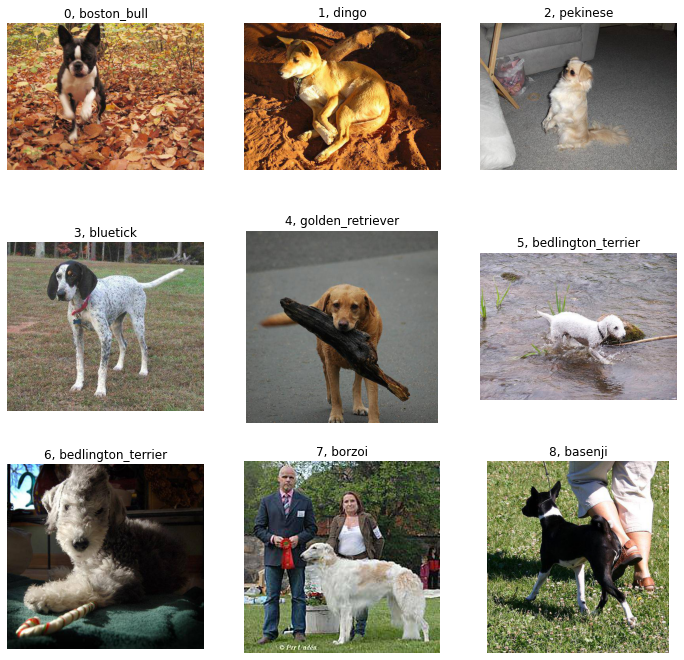

In [7]:
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('/content/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

14540800/14536120 [==============================] - 1s 0us/step


In [9]:
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [11]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input
image_size = 224 
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)
train_generator = train_datagen.flow_from_directory(directory="/content/train_sub/", subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory="/content/train_sub/", subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical", target_size=(image_size, image_size))

Using TensorFlow backend.


Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
241/241 [==============================] - 116s 480ms/step - loss: 3.1259 - accuracy: 0.3266 - val_loss: 1.5723 - val_accuracy: 0.5771
Epoch 2/20
241/241 [==============================] - 113s 467ms/step - loss: 1.5209 - accuracy: 0.6250 - val_loss: 1.2146 - val_accuracy: 0.6446
Epoch 3/20
241/241 [==============================] - 112s 464ms/step - loss: 1.1825 - accuracy: 0.6909 - val_loss: 1.0702 - val_accuracy: 0.6769
Epoch 4/20
241/241 [==============================] - 112s 464ms/step - loss: 1.0167 - accuracy: 0.7248 - val_loss: 1.0906 - val_accuracy: 0.6685
Epoch 5/20
241/241 [==============================] - 112s 465ms/step - loss: 0.9101 - accuracy: 0.7542 - val_loss: 1.0038 - val_accuracy: 0.7005
Epoch 6/20
241/241 [==============================] - 111s 462ms/step - loss: 0.8119 - accuracy: 0.7744 - val_loss: 0.9691 - val_accuracy: 0.7137
Epoch 7/20
241/241 [============================

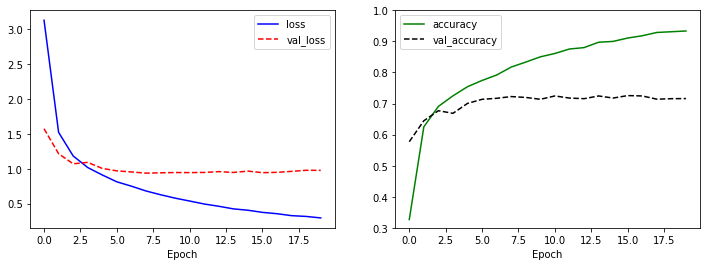

In [12]:
steps_per_epoch = int(7718/32) 
history = model.fit_generator(train_generator, validation_data=valid_generator, epochs=20, steps_per_epoch=steps_per_epoch)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.3, 1)
plt.legend()

plt.show()

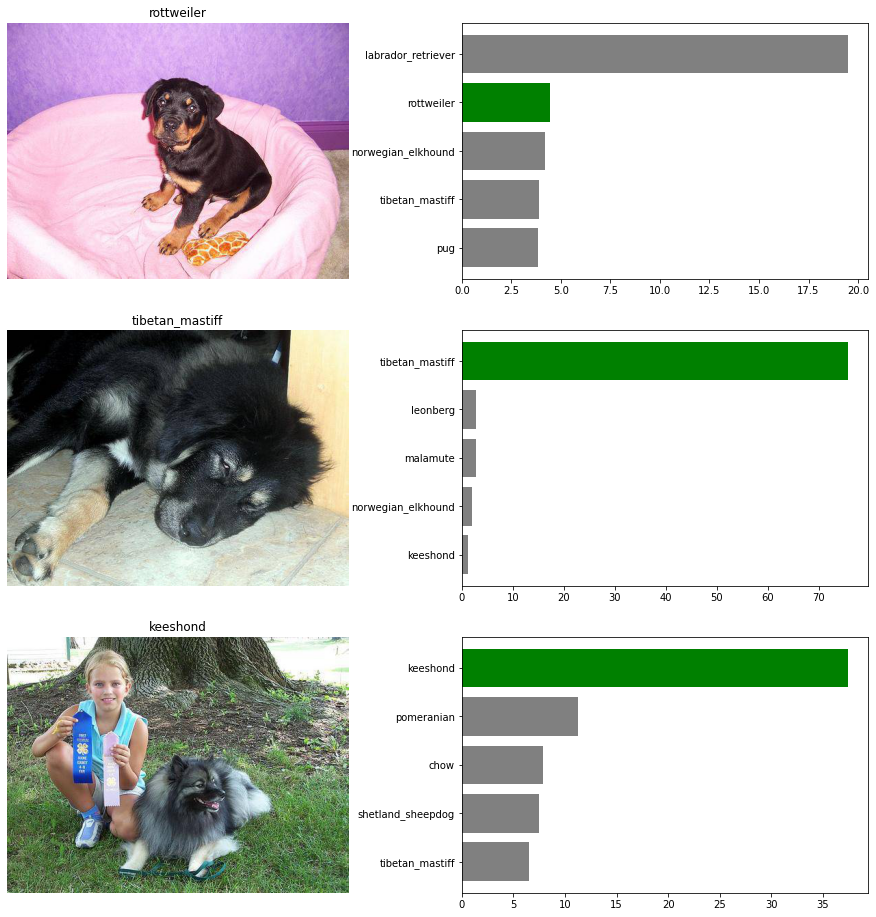

In [18]:
import random
import cv2
import numpy as np
plt.figure(figsize = (16,16))

unique_sorted_Y = sorted(unique_Y)

for c in range(3):
  image_path = random.choice(valid_generator.filepaths)
  plt.subplot(3,2,c*2+1)
  plt.imshow(plt.imread(image_path))
  real_y = image_path.split('/')[3]
  plt.title(real_y)
  plt.axis('off')
  idx = unique_sorted_Y.index(real_y)
  plt.subplot(3,2,c*2+2)
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize = (299,299))
  img = img /255.0
  img = np.expand_dims(img,axis = 0)
  prediction = model.predict(img)[0]

  top_5_predict = prediction.argsort()[::-1][:5]
  labels = [unique_sorted_Y[index] for index in top_5_predict]
  color = ['gray'] * 5
  if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
  color = color[::-1]
  plt.barh(range(5), prediction[top_5_predict][::-1]*100, color = color)
  plt.yticks(range(5), labels[::-1])